<a href="https://www.kaggle.com/code/sanyuktasingh5/a-b-testing?scriptVersionId=158924115" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abtesting/cookie_cats.csv


# **Notebook Content!**

1. [IMPORT LIBRARIES](#cell3)
2. [LOAD DATA](#cell5)
3. [SUMMARY STATS](#cell6)
4. [OUTLIERS](#cell7)
5. [SOME DETAILS](#cell8)
6. [A/B TESTING](#cell9)
7. [CONCLUSION](#cell10)

<a id="cell3"></a>
# **IMPORT LIBRARIES**

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

<a id="cell5"></a>
# **LOAD DATA**

In [3]:
read = pd.read_csv("/kaggle/input/abtesting/cookie_cats.csv")

In [4]:
read.shape

(90189, 5)

In [5]:
read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
read.describe()

,userid,sum_gamerounds
count,90189.0000,90189.0000
mean,4998412.2345,51.8725
std,2883285.6077,195.0509
min,116.0000,0.0000
25%,2512230.0000,5.0000
50%,4995815.0000,16.0000
75%,7496452.0000,51.0000
max,9999861.0000,49854.0000


In [7]:
read.isna().sum().sort_values(ascending=True)

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

<a id="cell6"></a>
# **SUMMARY STATS**

In [8]:
print(read.userid.nunique()== read.shape[0])

True


In [9]:
read.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [10]:
read.groupby('version')['sum_gamerounds'].agg(["count","median","mean","std","max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


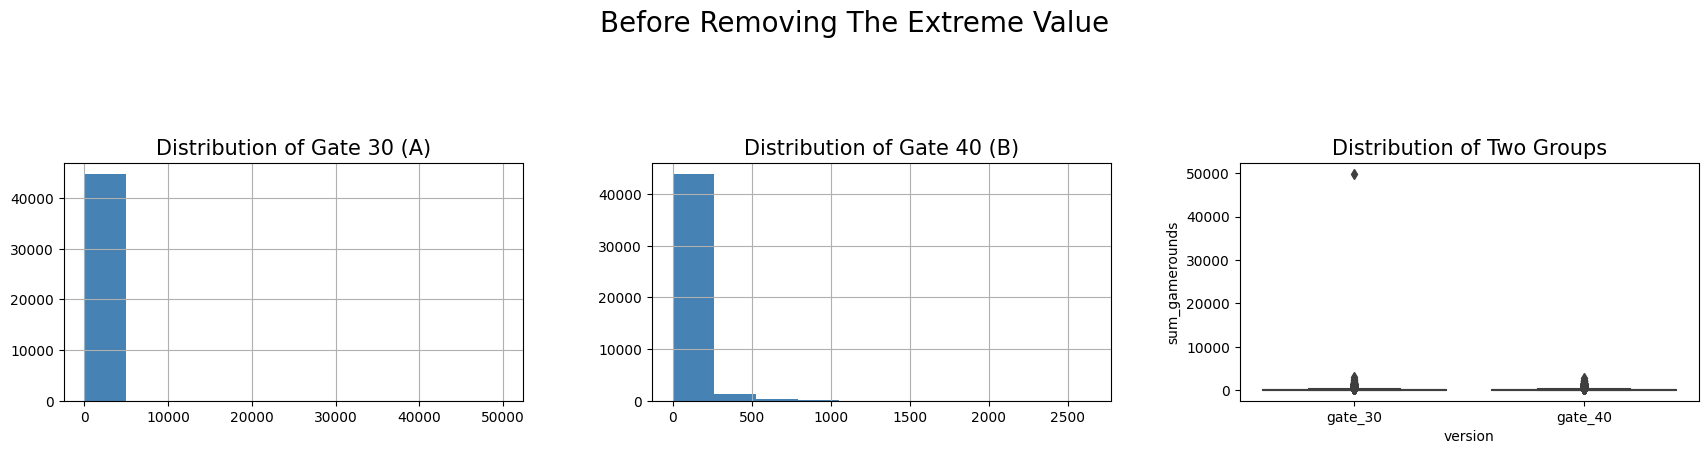

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
read[read['version']=="gate_30"].hist('sum_gamerounds',ax=axes[0],color='steelblue')
read[read['version']=="gate_40"].hist('sum_gamerounds',ax=axes[1],color='steelblue')
sns.boxplot(x=read.version,y=read.sum_gamerounds,ax=axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad=4)

Text(0.5, 0.98, 'Before Removing The Extreme Value')

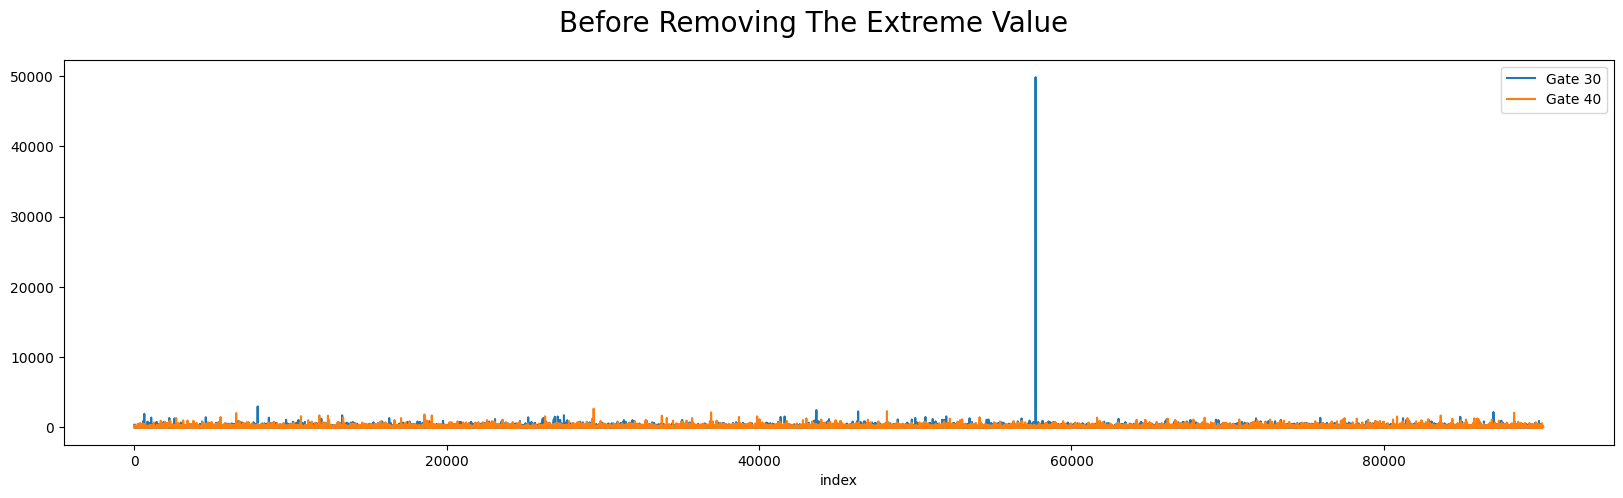

In [12]:
read[read.version=="gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend=True,label="Gate 30",figsize=(20,5))
read[read.version=="gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend=True,label="Gate 40",figsize=(20,5))
plt.suptitle("Before Removing The Extreme Value", fontsize=20)

<a id="cell7"></a>
# **OUTLIERS**

In [13]:
read = read[read.sum_gamerounds<read.sum_gamerounds.max()]
read.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


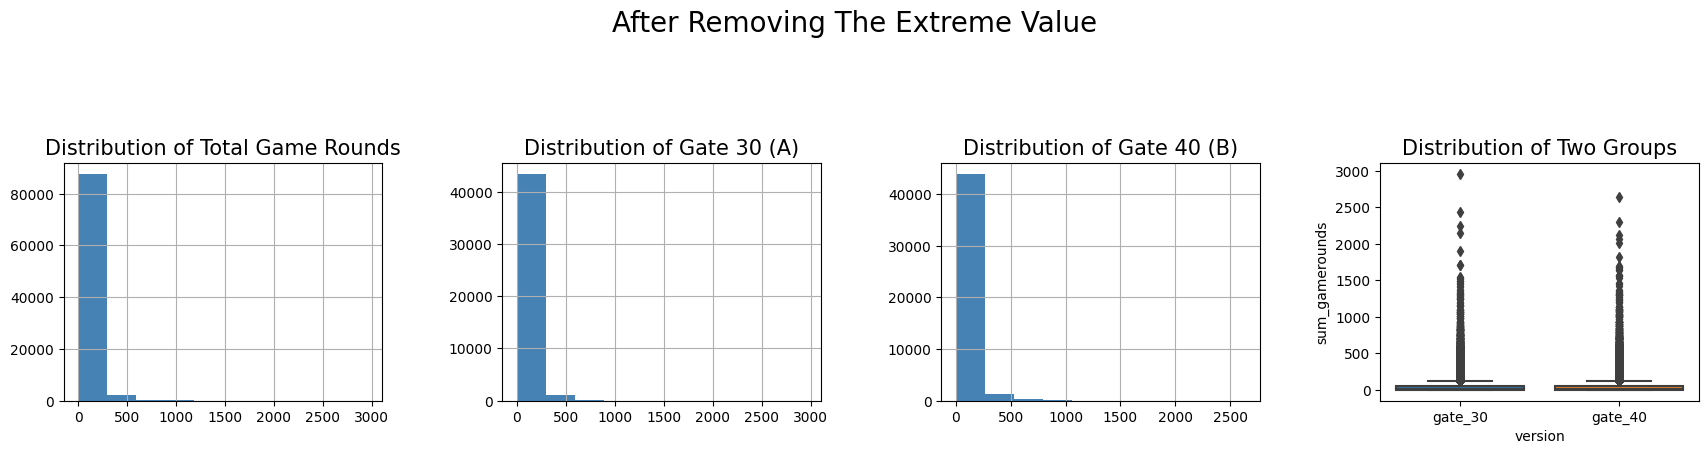

In [14]:
fig,axes = plt.subplots(1, 4, figsize=(18,5))
read.sum_gamerounds.hist(ax=axes[0],color='steelblue')
read[(read.version=="gate_30")].hist('sum_gamerounds',ax=axes[1],color='steelblue')
read[(read.version=="gate_40")].hist('sum_gamerounds',ax=axes[2],color='steelblue')
sns.boxplot(x=read.version,y=read.sum_gamerounds,ax=axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

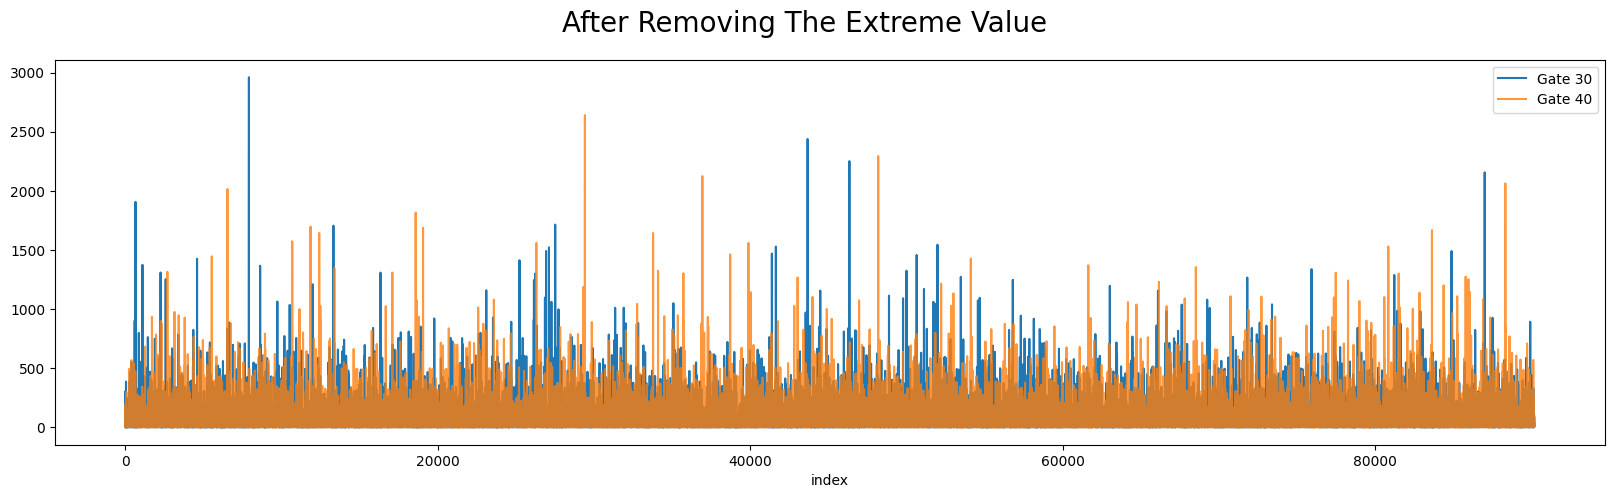

In [15]:
read[(read.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
read[read.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

<a id="cell8"></a>
# **SOME DETAILS**

The users installed the game but 3994 users never played the game! Some reasons might explain this situation.

* They have no free time to play game
* Users might prefer to play other games or they play other games already
* Some users don't like the app etc.
* You can comment below for this users also

The number of users decreases as the levels progress

* Most of users played the game at early stage and they didn't progress.
* Tactile Entertainment should learn why users churn playing the game.
* Doing research and collecting data about the game and users would help to understand user churn
* The difficulty of the game can be measured
* Gifts might help player retention

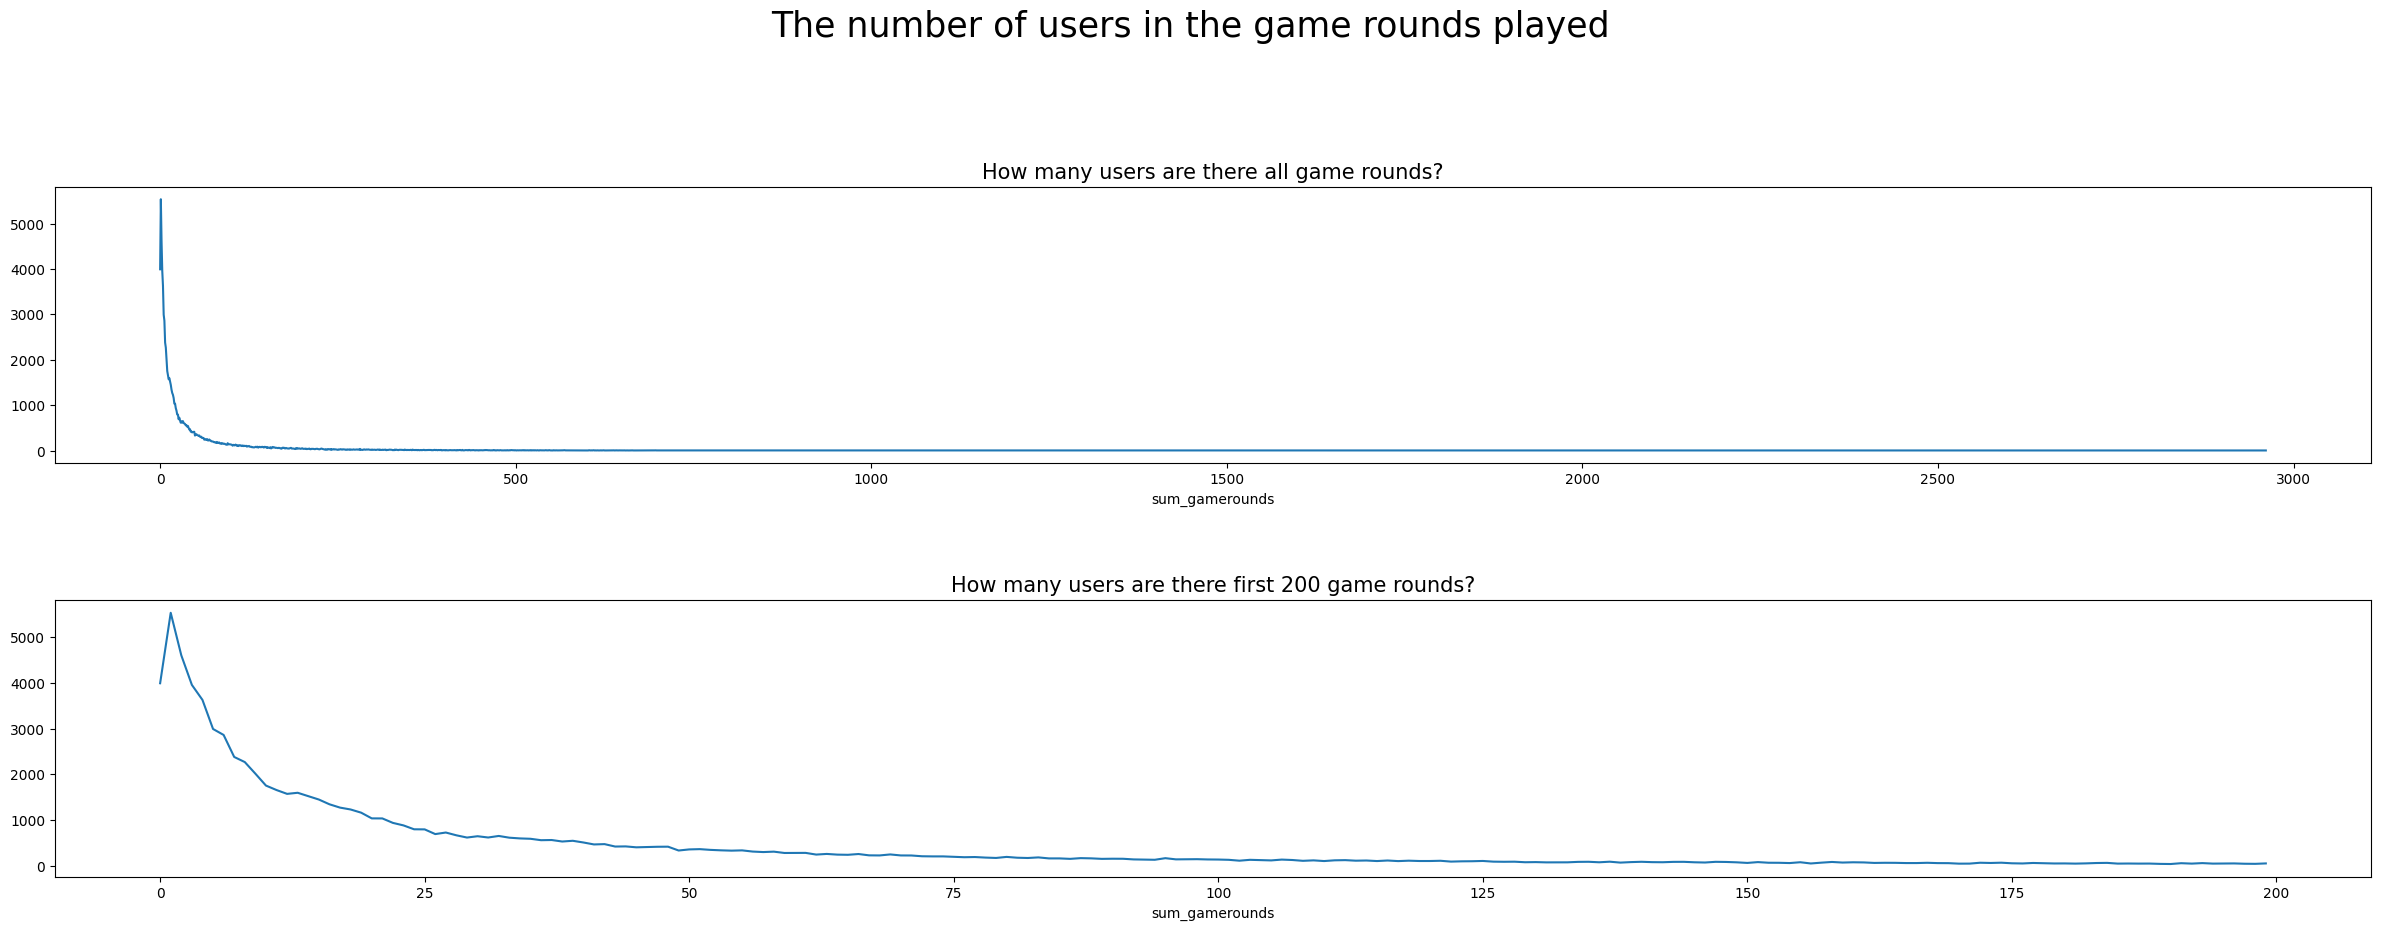

In [16]:
fig, axes = plt.subplots(2,1,figsize=(25,10))
read.groupby('sum_gamerounds').userid.count().plot(ax=axes[0])
read.groupby('sum_gamerounds').userid.count()[:200].plot(ax=axes[1])
plt.suptitle("The number of users in the game rounds played",fontsize=25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5)

In [17]:
read.groupby('sum_gamerounds').userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [18]:
read.groupby('sum_gamerounds').userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [19]:
read.groupby('version').sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


In [20]:
pd.DataFrame({"RET1_COUNT": read["retention_1"].value_counts(),
              "RET7_COUNT": read["retention_7"].value_counts(),
              "RET1_RATIO": read["retention_1"].value_counts() / len(read),
              "RET7_RATIO": read["retention_7"].value_counts() / len(read)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


In [21]:
read['Retention'] = np.where((read.retention_1==True) & (read.retention_7==True), 1,0)
read.groupby(['version','Retention'])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

In [22]:
read['NewRetention'] = list(map(lambda x,y: str(x)+"-"+str(y),read.retention_1,read.retention_7))
read.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0000,11.8197,21.6426,981
1,gate_30,False-True,1825,43.0000,73.1693,93.2223,1072
2,gate_30,True-False,13358,33.0000,49.6945,58.1254,918
3,gate_30,True-True,6676,127.0000,183.8863,189.6264,2961
4,gate_40,False-False,23597,6.0000,11.9133,20.9010,547
5,gate_40,False-True,1773,47.0000,75.2611,94.4780,1241
6,gate_40,True-False,13613,32.0000,50.0255,60.9246,2640
7,gate_40,True-True,6506,133.0000,190.2824,194.2201,2294


<a id="cell9"></a>
# **A/B TESTING**

Assumptions:

* Check normality
* If Normal Distribution, check homogeneity

Steps:

* Split & Define Control Group & Test Group
* Apply Shapiro Test for normality
* If parametric apply Levene Test for homogeneity of variances
* If Parametric + homogeneity of variances apply T-Test
* If Parametric - homogeneity of variances apply Welch Test
* If Non-parametric apply Mann Whitney U Test directly

In [23]:
read["version"] = np.where(read.version == "gate_30", "A", "B")
read.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [24]:
def AB_Test(dataframe,group,target):
    
    from scipy.stats import shapiro
    
    groupA = dataframe[dataframe[group]=='A'][target]
    groupB = dataframe[dataframe[group]=='B'][target]
    
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    if (ntA==False) & (ntB==False):
        
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
        if leveneTest == False:
            
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        
        else:
            
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            
    else:
        
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        
        
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    
    temp['Test Type'] = np.where((ntA==False) & (ntB==False), 'Parametric', 'Non-Parametric')
    temp['AB Hypothesis'] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp['comment'] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    if (ntA==False) & (ntB==False):
        
        temp['Honogeneity'] = np.where(leveneTest==False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "comment"]]
        
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "comment"]]
        
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

AB_Test(dataframe = read, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,comment
0,Non-Parametric,Fail to Reject H0,0.0509,A/B groups are similar!


<a id="cell10"></a>
# **CONCLUSION**

Remember business problem!
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.

Before A/B Testing, we shared some details about game, players, problems and suggestion to our customer/director/ceo etc.

After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Briefly, There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.

 Which level has more advantages in terms of player retention?
1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.